# Simple Variational Auto Encoder

This code template is for Anomaly detection/outlier analysis using the Simple Variational Auto Encoder. This template utilizes Variational Auto Encoder implementation from the pyod library. A variational autoencoder can be defined as an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable a generative process.

### Required Packages

In [ ]:
!pip install plotly
!pip install pyod
!pip install tensorflow #For Variational Auto Encoder 

In [3]:
import time
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from pyod.models.vae import VAE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

### Initialization

Filepath of CSV file

In [4]:
file_path= ""

List of features which are  required for model training .

In [8]:
features=[]

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [5]:
df=pd.read_csv(file_path);
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X.

In [9]:
X=df[features]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [10]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature set.


In [11]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])  
X=EncodeX(X)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


### Data Splitting

The train-test split is a procedure for evaluating the performance of an algorithm. The procedure involves taking a dataset and dividing it into two subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [12]:
x_train,x_test=train_test_split(X,test_size=0.2,random_state=123)

### Model

Variational Auto Encoder (VAE) is a type of neural networks for learning useful latent representations. 
Variational autoencoder provides a probabilistic manner for describing an observation in latent space.

### Tuning Parameters
    ncoder_neurons : list, optional (default=[128, 64, 32])
        The number of neurons per hidden layer in encoder.

    decoder_neurons : list, optional (default=[32, 64, 128])
        The number of neurons per hidden layer in decoder.

    hidden_activation : str, optional (default='relu')
        Activation function to use for hidden layers.
        All hidden layers are forced to use the same type of activation.
        See https://keras.io/activations/

    output_activation : str, optional (default='sigmoid')
        Activation function to use for output layer.
        See https://keras.io/activations/

    loss : str or obj, optional (default=keras.losses.mean_squared_error
        String (name of objective function) or objective function.
        See https://keras.io/losses/

    gamma : float, optional (default=1.0)
        Coefficient of beta VAE regime.
        Default is regular VAE.

    capacity : float, optional (default=0.0)
        Maximum capacity of a loss bottle neck.

    optimizer : str, optional (default='adam')
        String (name of optimizer) or optimizer instance.
        See https://keras.io/optimizers/

    epochs : int, optional (default=100)
        Number of epochs to train the model.


**For More Details** [Variational Auto Encoder API](https://pyod.readthedocs.io/en/latest/_modules/pyod/models/vae.html)

In [13]:
#Inner and Outer Encoder Units must be symmetric in the model i.e [outer_units,inner_units,inner_units,outer_units]
outer_units = x_train.shape[1]
inner_units = round(x_train.shape[1]/2) #Inner Encoder Units must be <= Number of features

In [14]:
model = VAE(epochs=10, 
                    contamination=0.05, 
                    encoder_neurons = [outer_units,inner_units],
                    decoder_neurons = [inner_units,outer_units]) 
model.fit(x_train)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 9)            90          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 9)            90          dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 9)            0           dense_1[0][0]                    
______________________________________________________________________________________________

VAE(batch_size=32, capacity=0.0, contamination=0.05, decoder_neurons=[4, 9],
  dropout_rate=0.2, encoder_neurons=[9, 4], epochs=10, gamma=1.0,
  hidden_activation='relu', l2_regularizer=0.1, latent_dim=2,
  loss=<function mean_squared_error at 0x7f82a19205f0>, optimizer='adam',
  output_activation='sigmoid', preprocessing=True, random_state=None,
  validation_size=0.1, verbose=1)

### Anomaly Prediction

In [15]:
result=x_test.copy(deep=True)
result['Anomaly']=model.predict(x_test)
result.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,Anomaly
19121,-122.64,38.24,40.0,1974.0,410.0,1039.0,398.0,3.7917,151600.0,0
20019,-119.05,36.09,9.0,3297.0,568.0,1749.0,568.0,4.0217,99200.0,0
15104,-116.98,32.85,12.0,3570.0,713.0,3321.0,666.0,4.0882,134500.0,0
3720,-118.42,34.20,27.0,3201.0,970.0,3403.0,948.0,2.2377,231700.0,0
8938,-118.47,34.01,41.0,2704.0,557.0,1047.0,478.0,4.4211,462900.0,0


### Anomaly Visualization

#### Bar Plot

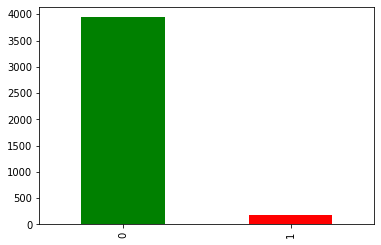

In [16]:
result['Anomaly'].value_counts().plot(kind='bar',color=['green','red'])

#### Pie Chart

In [17]:
fig = px.pie(result['Anomaly'],names=result['Anomaly'], title='Anomaly rate',)
fig.show()

#### Anomalies

In this part we will perform Dimensionality Reduction technique to visualize data. This can be performed using technique such as PCA or TSNE algorithms.

In [18]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(result.drop('Anomaly',axis=1))

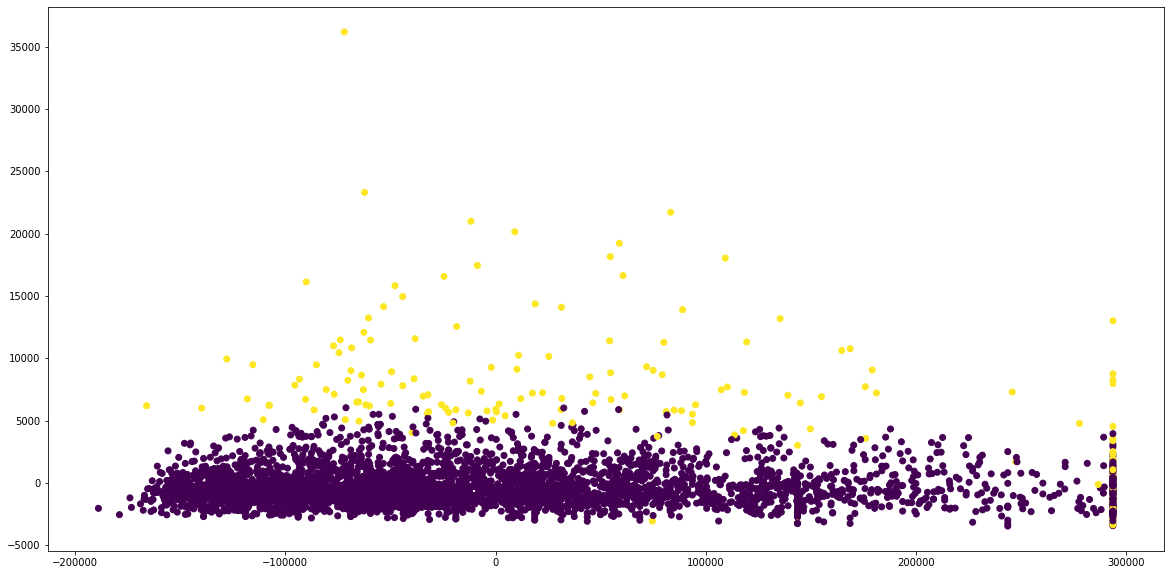

In [19]:
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(x=pca_results[:,0],y=pca_results[:,1],c=result.iloc[:,result.columns.get_loc('Anomaly')])
plt.show()

#### Creator: Arpit Somani, Github: [Profile](https://github.com/arpitsomani8)